In [1]:
import fmEphys

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [2]:
import os

from tqdm import tqdm

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.backends.backend_pdf import PdfPages

In [3]:
%matplotlib inline

In [4]:
cfg_path = '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/041422/J599RT/pipeline_cfg.yml'
session = fmEphys.Session(cfg_path)

In [ ]:
# cfg_path = '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/041422/J599RT/pipeline_cfg.yml'
# session = fmEphys.Session(cfg_path)

In [5]:
session.get_session_recordings()

In [6]:
session.recordings_dict

{'hf1_revchecker500ms': '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/041422/J599RT/hf1_revchecker500ms'}

In [7]:
# recording_path = session.recordings_dict['hf2_sparsenoiseflash500msISI']
# cfg = session.cfg

KeyError: 'hf2_sparsenoiseflash500msISI'

In [23]:
recording_name = fmEphys.auto_recording_name(recording_path)
recording_name

'041422_J599RT_control_Rig2_hf2_sparsenoiseflash500msISI'

In [24]:
sn = fmEphys.HeadFixedSparseNoise(cfg, recording_name, recording_path)

In [28]:
sn.detail_pdf = PdfPages(os.path.join(sn.recording_path, (sn.recording_name + '_detailed_analysis_figures_TEST.pdf')))
sn.diagnostic_pdf = PdfPages(os.path.join(sn.recording_path, (sn.recording_name + '_diagnostic_analysis_figures_TEST.pdf')))

In [29]:
sn.base_ephys_analysis()

gathering files
opening worldcam
opening running ball
opening ephys
opening eyecam
aligning timestamps to ephys
dropping static worldcam pixels
firing rates at new timebase
contrast response functions
mua power profile laminar depth
interpolating worldcam data to match model timebase
calculating stas
calculating multilag stas
calculating stvs
saccade psths
All eye movements


80it [00:47,  1.70it/s]


tuning to pupil properties
tuning to movement signals


In [33]:
sn.Sn_world = xr.open_dataset(sn.world_path)
vid = sn.Sn_world.WORLD_video.values.astype(np.uint8).astype(float)

In [34]:
sn.unit_stim_eventT = {}

In [35]:
# when does the stimulus change?
dStim = np.sum(np.abs(np.diff(vid, axis=0)), axis=(1,2))
flips = np.argwhere((dStim[1:]>sn.Sn_dStim_thresh) * (dStim[:-1]<sn.Sn_dStim_thresh)).flatten()

In [58]:
contrast = np.nanstd(vid, axis=(1,2))

In [98]:
np.size(sn.worldT)

73023

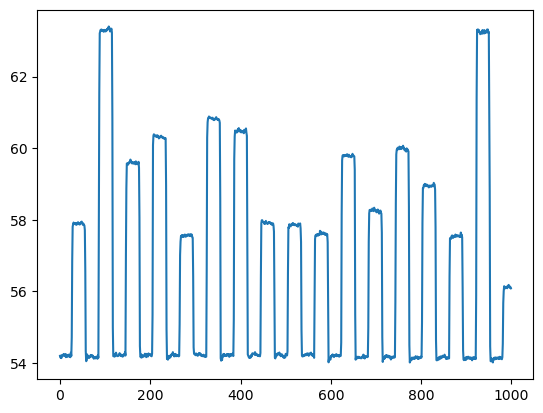

In [62]:
plt.plot(contrast[:1000])

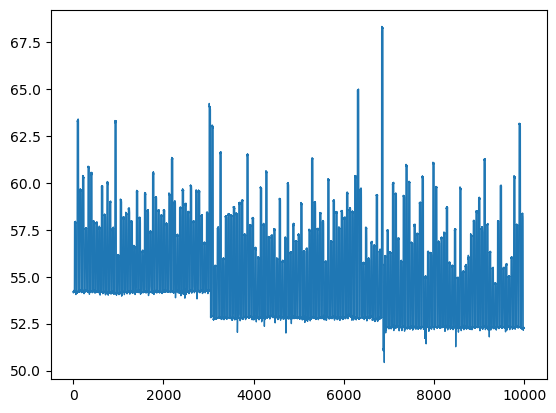

In [88]:
plt.plot(contrast[:10000], linewidth=1)#[contrast<55])
# plt.hlines(np.median(contrast[contrast<55]), 0, 35000, 'k')

In [101]:
block_times = {}
sT = 0
for ch in range(int(np.ceil(np.size(sn.worldT)/3600))):
    if sT+3600>np.size(sn.worldT):
        endT = np.size(sn.worldT)
    else:
        endT = sT+3600
    block_times[ch] = (sT, endT)
    sT = endT

In [102]:
block_times

{0: (0, 3600),
 1: (3600, 7200),
 2: (7200, 10800),
 3: (10800, 14400),
 4: (14400, 18000),
 5: (18000, 21600),
 6: (21600, 25200),
 7: (25200, 28800),
 8: (28800, 32400),
 9: (32400, 36000),
 10: (36000, 39600),
 11: (39600, 43200),
 12: (43200, 46800),
 13: (46800, 50400),
 14: (50400, 54000),
 15: (54000, 57600),
 16: (57600, 61200),
 17: (61200, 64800),
 18: (64800, 68400),
 19: (68400, 72000),
 20: (72000, 73023)}

In [106]:
flips[(flips<block_times[2][1]) * (flips>block_times[2][0])]

array([ 7314,  7344,  7374,  7404,  7434,  7464,  7673,  7703,  7733,
        7763,  7793,  7823,  7972,  8002,  8062,  8210,  8240,  8270,
        8300,  8449,  8479,  8569,  8599,  8806,  8867,  8897,  8926,
        8986,  9045,  9075,  9105,  9136,  9225,  9255,  9465,  9495,
        9585,  9615,  9764,  9794,  9883,  9914,  9973, 10002, 10033,
       10122, 10152, 10182, 10212, 10302, 10332, 10362, 10392, 10482,
       10512, 10721, 10751, 10780])

In [111]:
stim_eventT = []
grey_eventT = []

for ch, times in block_times.items():
    grey_val = np.nanmedian(contrast[times[0]:times[1]])
    
    _block_flips = flips.copy()[(flips<times[1]) * (flips>times[0])]
    check_ind = _block_flips+10
    eventT = sn.worldT[_block_flips+1].values
    
    event_dict = dict(zip(check_ind, eventT))
    
    for f, t in event_dict.items():
        if f >= np.size(contrast):
            continue
        # if it is a grey screen
        if contrast[f] < grey_val:
            grey_eventT.append(t)

        # otherwise, it was the stimulus
        elif contrast[f] > grey_val:
            stim_eventT.append(t)

In [121]:
stim_eventT = np.array(stim_eventT)

In [122]:
grey_eventT = np.array(grey_eventT)

In [123]:
_offset_time = (1/120)
Sn_psth = np.zeros([len(sn.cells.index.values), 2001, 2]) # last dim: [stim, grey]

for cell_i, ind in tqdm(enumerate(sn.cells.index.values)):
    
    unit_spikeT = sn.cells.loc[ind, 'spikeT']
    
    Sn_psth[cell_i,:,0] = sn.calc_kde_PSTH(unit_spikeT, stim_eventT+_offset_time)
    
    Sn_psth[cell_i,:,1] = sn.calc_kde_PSTH(unit_spikeT, grey_eventT+_offset_time)

80it [00:46,  1.71it/s]


In [129]:
np.save('/home/niell_lab/Desktop/041422RT_sparse_noise_ISI_PSTHs.npy', Sn_psth)

In [133]:
Rc_df = pd.read_hdf('/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/041422/J599RT/hf1_revchecker500ms/041422_J599RT_control_Rig2_hf1_revchecker500ms_ephys_props.h5')

In [134]:
Rc_df.columns

Index(['Rc_Amplitude', 'Rc_ContamPct', 'Rc_KSLabel', 'Rc_amp', 'Rc_ch',
       'Rc_depth', 'Rc_fr', 'Rc_group', 'Rc_n_spikes', 'Rc_sh', 'Rc_waveform',
       'Rc_spikeT', 'Rc_t0', 'Rc_spikeTraw', 'Rc_rate', 'Rc_contrast',
       'Rc_contrast_tuning_bins', 'Rc_contrast_tuning',
       'Rc_contrast_tuning_err', 'Rc_spike_triggered_average',
       'Rc_spike_triggered_variance', 'Rc_saccade_rightT', 'Rc_saccade_leftT',
       'Rc_saccade_rightPSTH', 'Rc_saccade_leftPSTH',
       'Rc_pupilradius_tuning_bins', 'Rc_pupilradius_tuning',
       'Rc_pupilradius_tuning_err', 'Rc_theta_tuning_bins', 'Rc_theta_tuning',
       'Rc_theta_tuning_err', 'Rc_phi_tuning_bins', 'Rc_phi_tuning',
       'Rc_phi_tuning_err', 'Rc_eyeT', 'Rc_dEye_dpf', 'Rc_dEye', 'Rc_theta',
       'Rc_phi', 'Rc_ballspeed', 'Rc_ballspeed_tuning_bins',
       'Rc_ballspeed_tuning', 'Rc_ballspeed_tuning_err',
       'Rc_response_by_channel', 'Rc_current_source_density',
       'Rc_relative_depth', 'Rc_layer4cent', 'Rc_stim_PSTH'

In [138]:
Rc_df.reset_index(inplace=True)

In [136]:
psth_bins = np.arange(-1,1.001,1/1000)

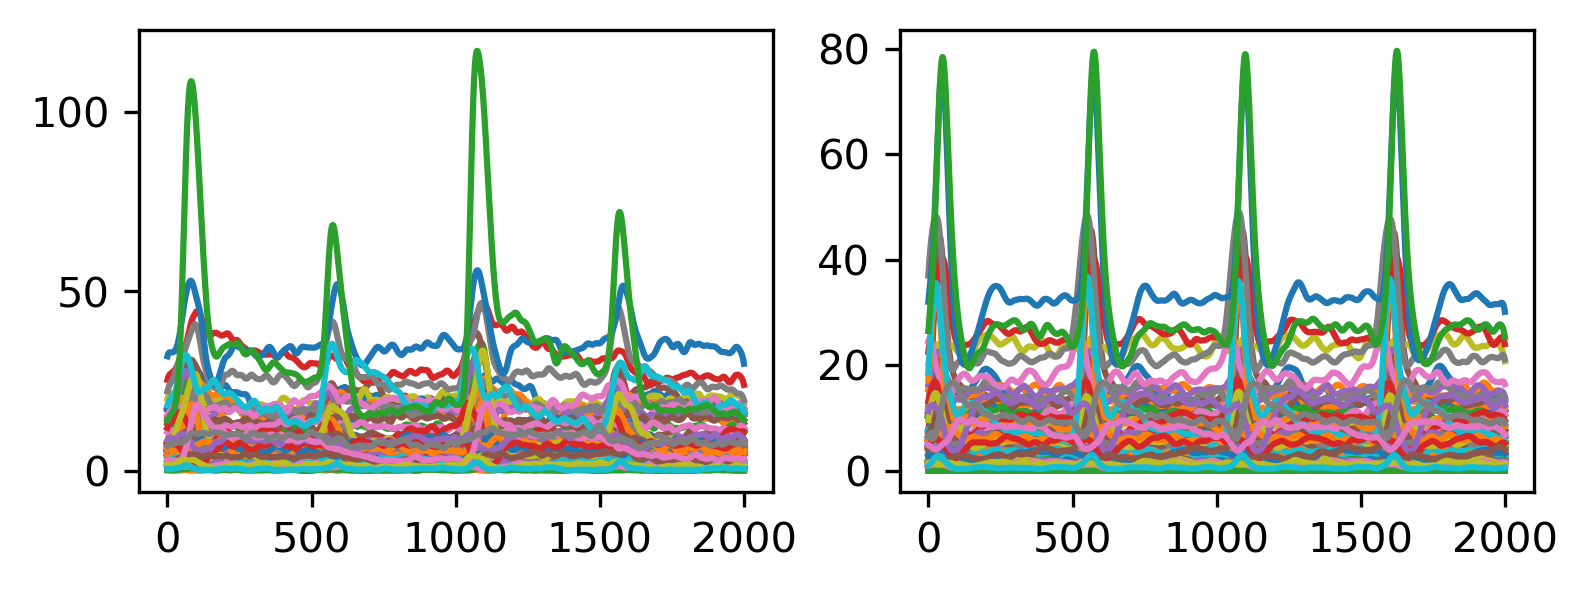

In [139]:
fig, [ax0, ax1] = plt.subplots(1,2,dpi=300,figsize=(6,2))

for i in range(0,80):
    
    ax0.plot(Sn_psth[i,:,0])
    
    ax1.plot(Rc_df.loc[i,'Rc_stim_PSTH'])
    

In [153]:
def normalize_psth(psth, raw_pref=None, baseline_val=None):
    if raw_pref is None:
        raw_pref = psth.copy()
    if baseline_val is None:
        baseline_val = np.mean(psth[0:800].astype(float))
    norm_psth = (psth - baseline_val) / np.max(raw_pref[750:1250].astype(float)) # [1000:1250]
    return norm_psth

def psth_modind(psth, zero_as_base=False):

    psth = psth.astype(float)
    if zero_as_base is False:
        use = psth - np.mean(psth[0:800].copy())
    elif zero_as_base is True:
        use = psth - psth[1000]
    mod = np.max(np.abs(use[1000:1250]))
    
    return mod

In [154]:
# normalize RC PSTHs
for ind, row in Rc_df.iterrows():
    Rc_df.at[ind, 'norm_Rc_psth'] = normalize_psth(row['Rc_stim_PSTH'], baseline_val=row['Rc_stim_PSTH'][1000]).astype(object)

# Eliminate unresponsive neurons
for ind, row in Rc_df.iterrows():
    
    raw_psth = row['Rc_stim_PSTH']
    Rc_df.at[ind, 'raw_mod_at_pref_peak'] = psth_modind(raw_psth, zero_as_base=True)
    
    norm_psth = row['norm_Rc_psth']
    Rc_df.at[ind, 'norm_mod_at_pref_peak'] = psth_modind(norm_psth, zero_as_base=True)

In [185]:
# Remove unresponsive from PCA inputs that will become the clustering x input
Rc_df['pca_input'] = Rc_df['norm_Rc_psth'].copy()

for ind, row in Rc_df.iterrows():
    if (row['raw_mod_at_pref_peak']>1) and (row['norm_mod_at_pref_peak']>0.1):
        Rc_df.at[ind,'pca_input'] = row['norm_Rc_psth'].astype(object)
    else:
        Rc_df.at[ind,'pca_input'] = np.zeros(2001).astype(object)

In [186]:
pca_input = fmEphys.flatten_series(Rc_df['pca_input'])[:,950:1300]


In [169]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [187]:
n_pcas = 10

pca = PCA(n_components=10)
pca.fit(pca_input)

PCA(n_components=10)

In [188]:
explvar = pca.explained_variance_ratio_

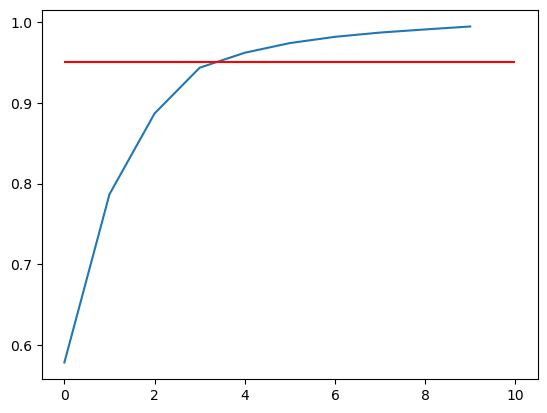

In [189]:
plt.plot(np.cumsum(explvar))
plt.hlines(0.95,0,10,'r')

In [190]:
proj = pca.transform(pca_input)

keep_pcas = int(np.argwhere(np.cumsum(explvar)>.95)[0])
print('using best {} PCs'.format(keep_pcas))

using best 4 PCs


In [191]:
gproj = proj[:,:keep_pcas]

km = KMeans(n_clusters=5)
km.fit_predict(gproj)
Z = km.labels_

In [192]:
np.unique(Z, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([18, 34, 11,  7, 10]))

In [ ]:
for 

In [ ]:
Rc_df.loc[i,'Rc_stim_PSTH']

In [ ]:
psth_bins = np.arange(-1,1.001,1/1000)

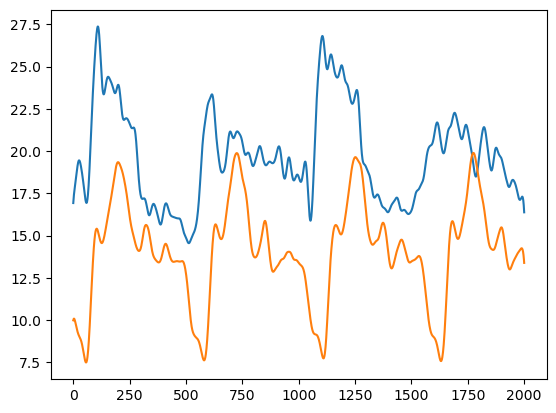

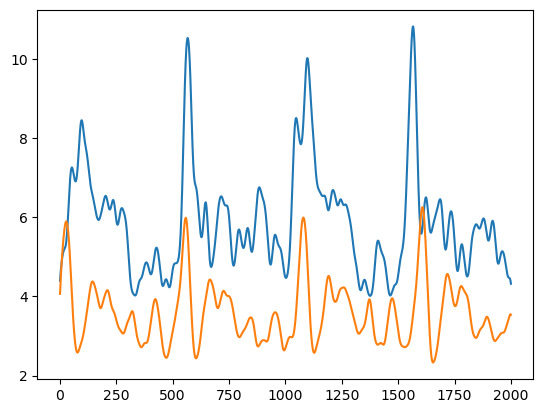

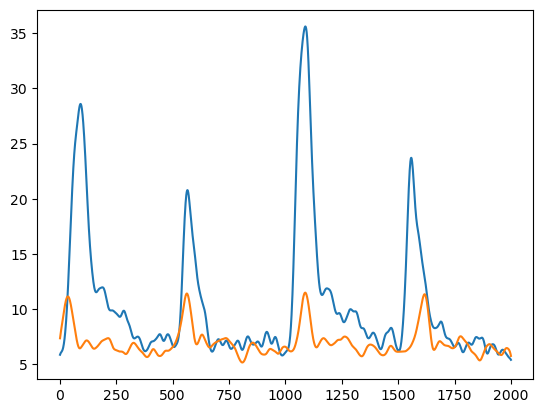

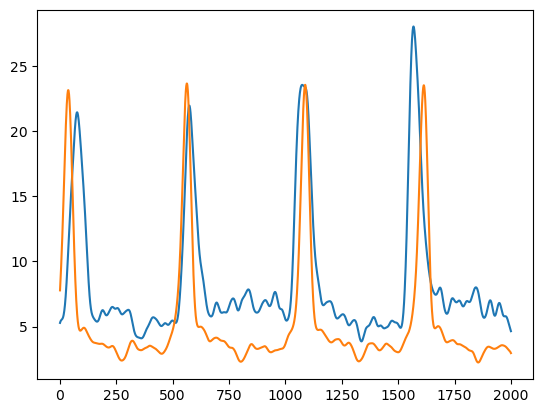

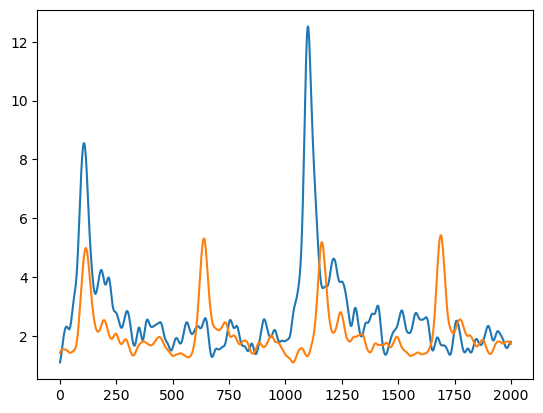

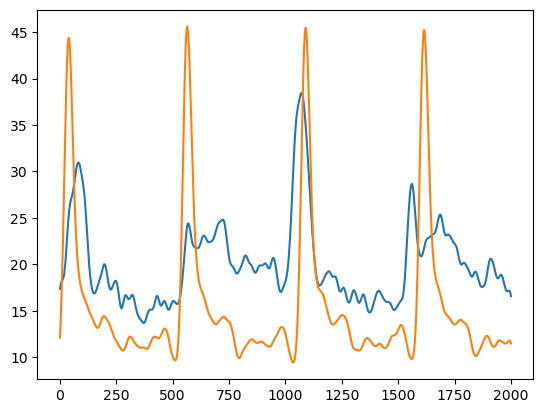

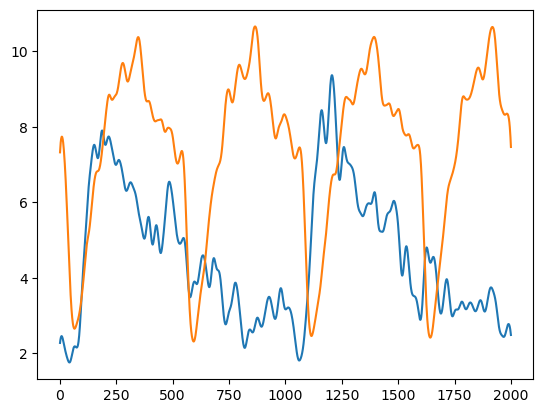

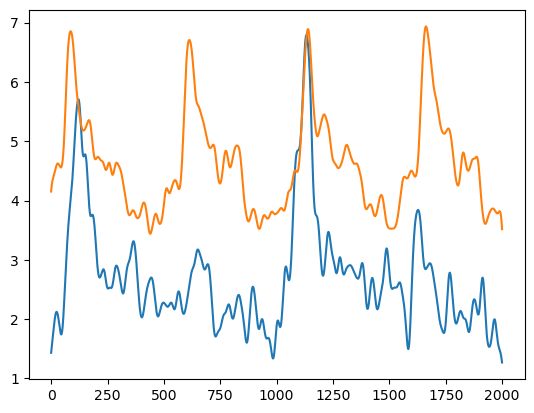

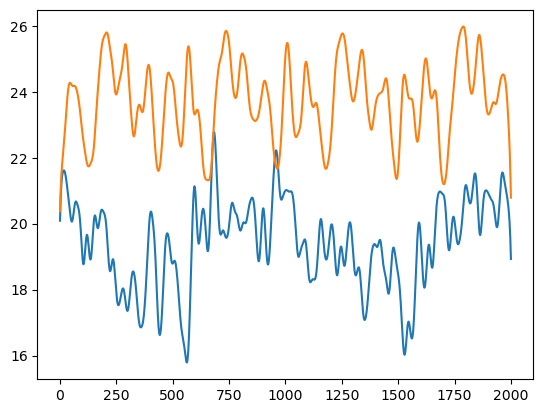

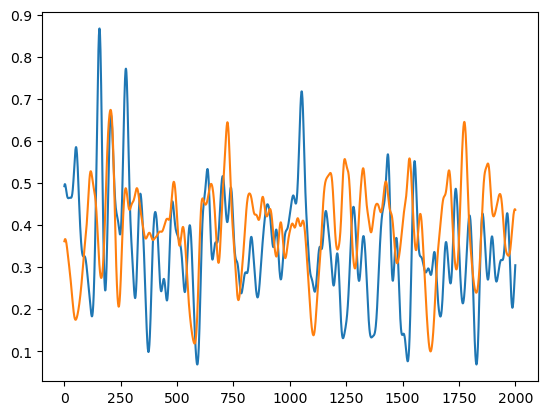

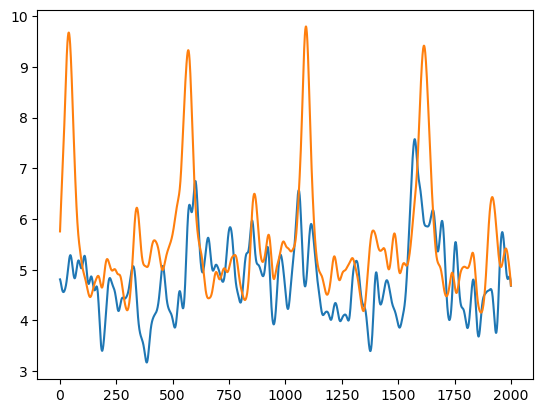

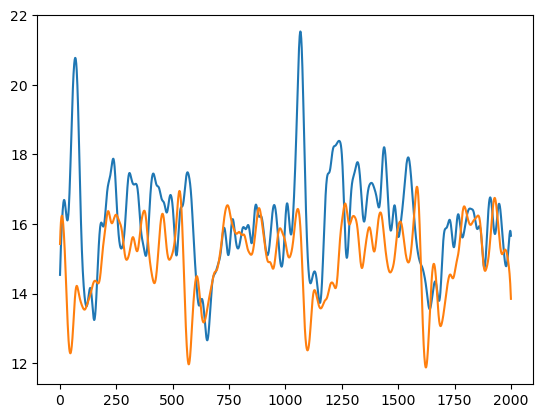

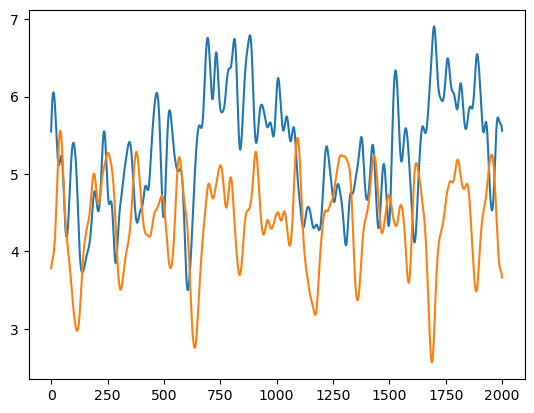

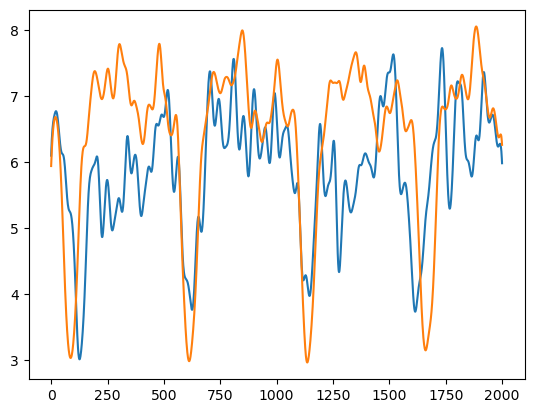

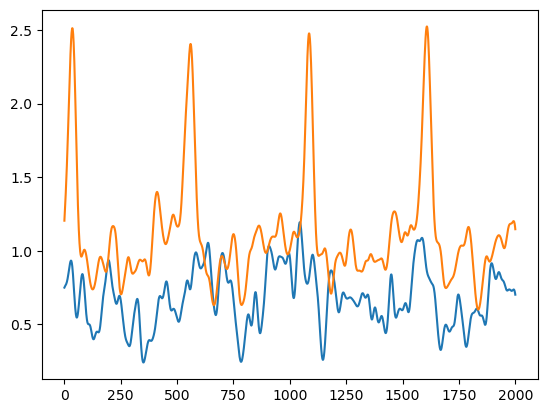

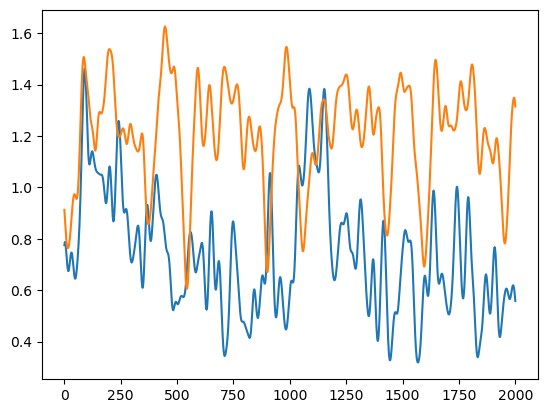

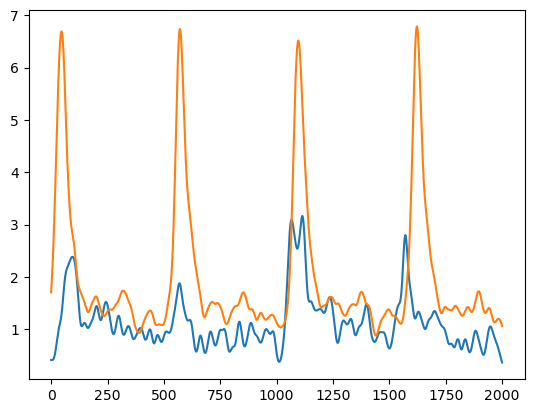

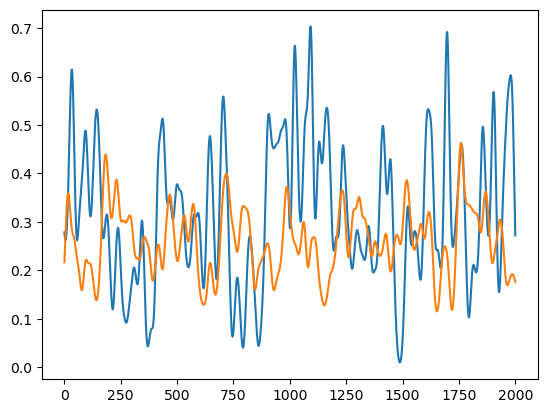

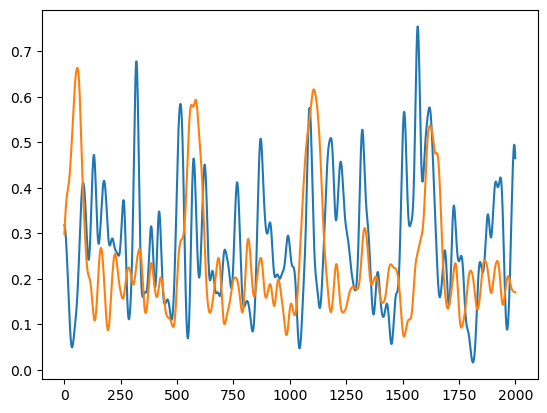

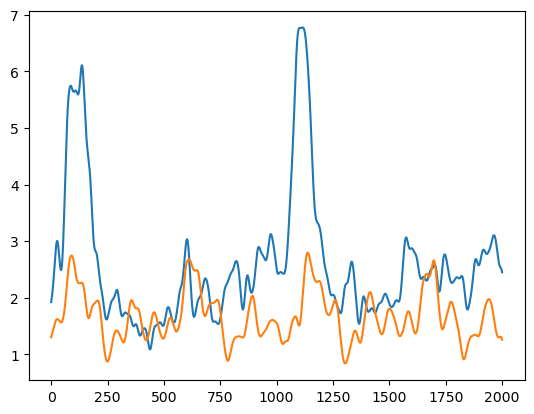

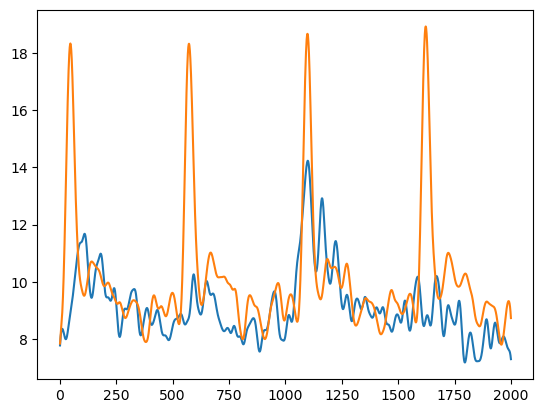

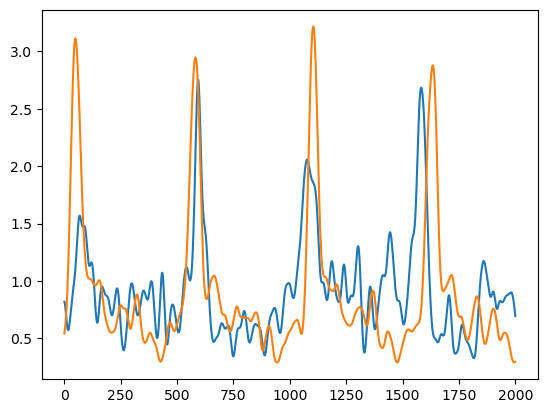

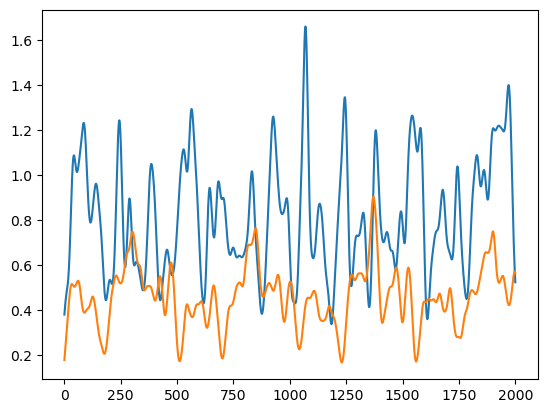

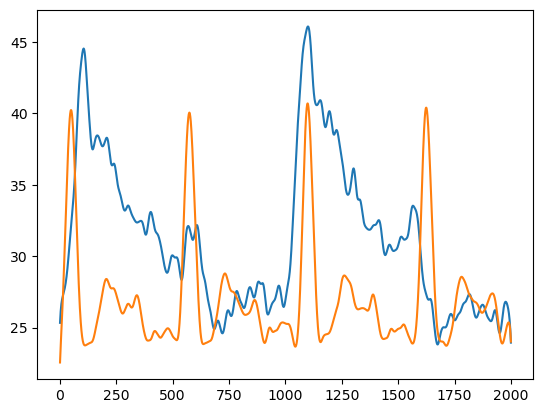

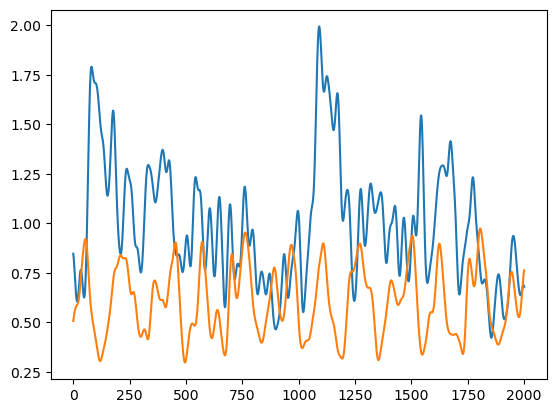

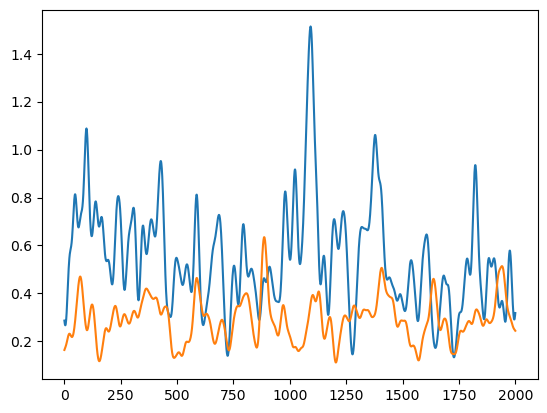

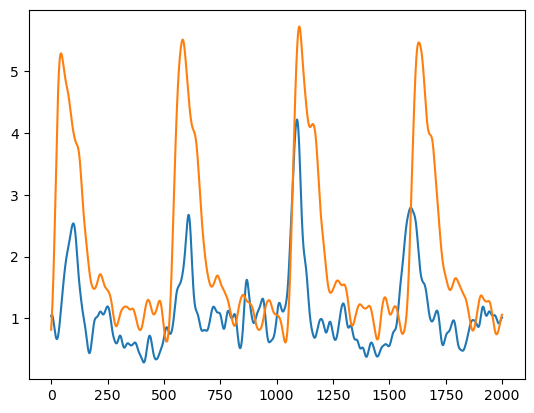

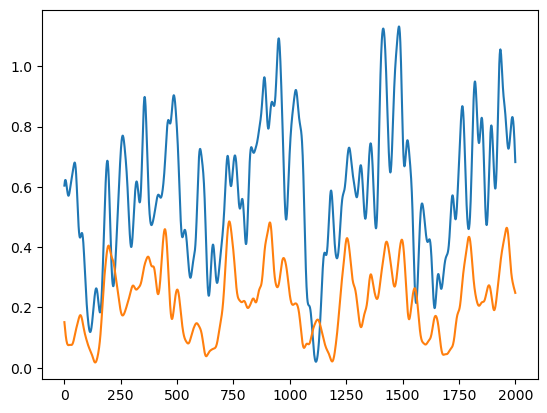

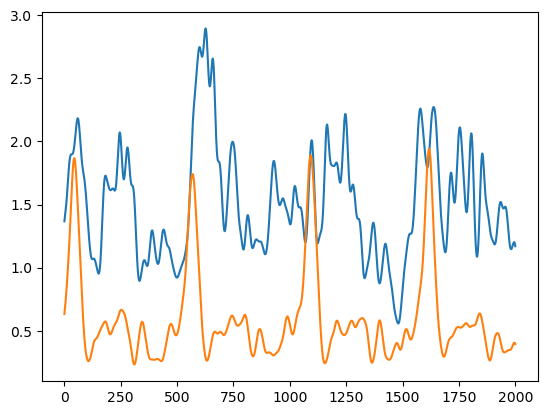

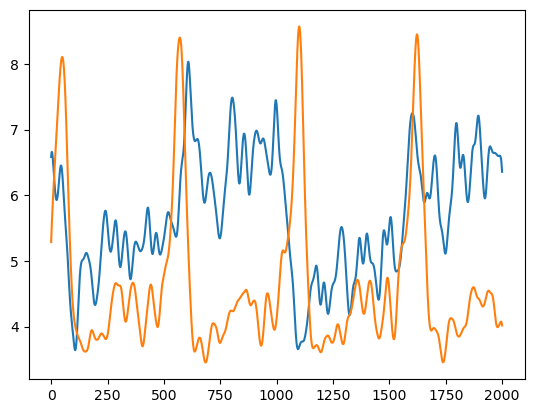

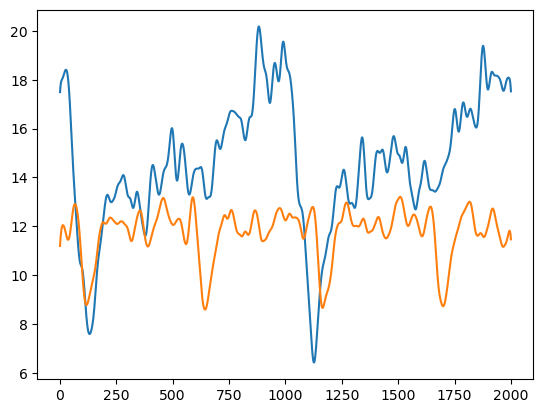

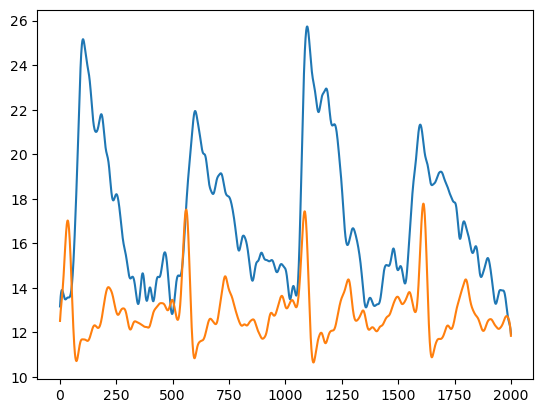

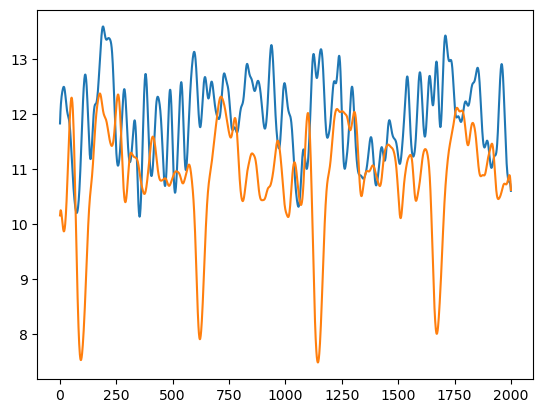

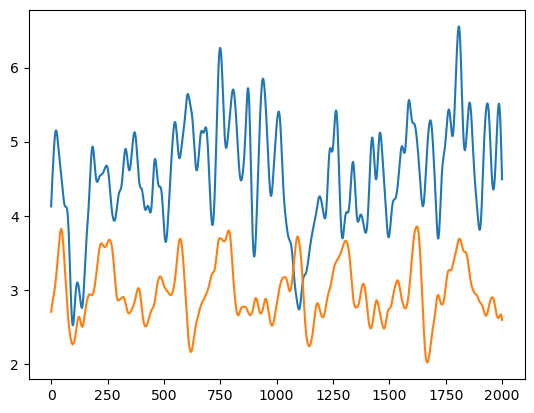

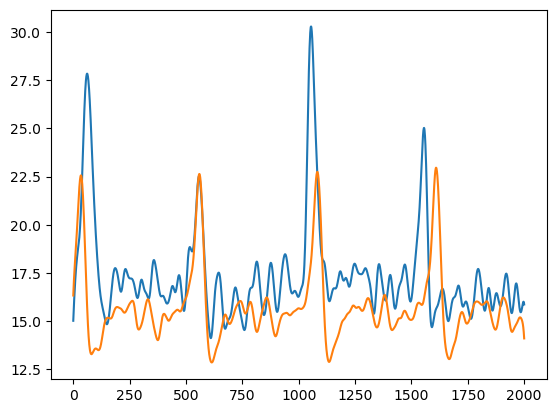

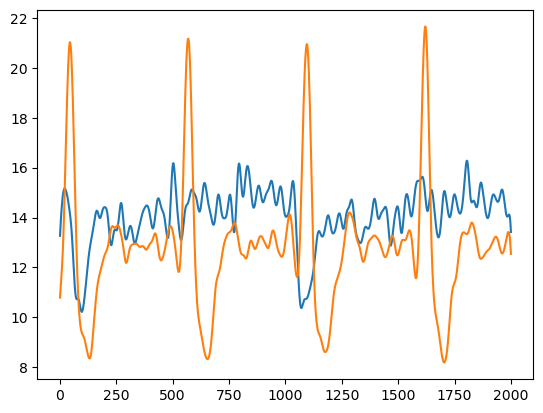

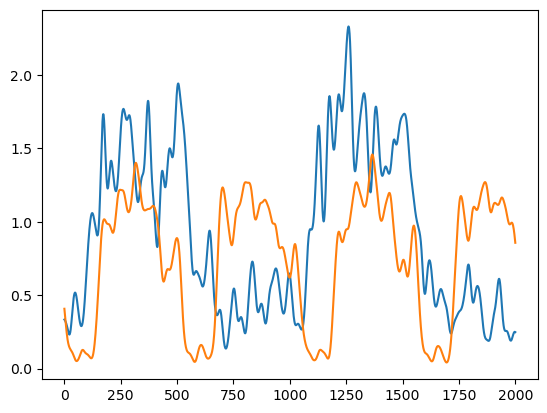

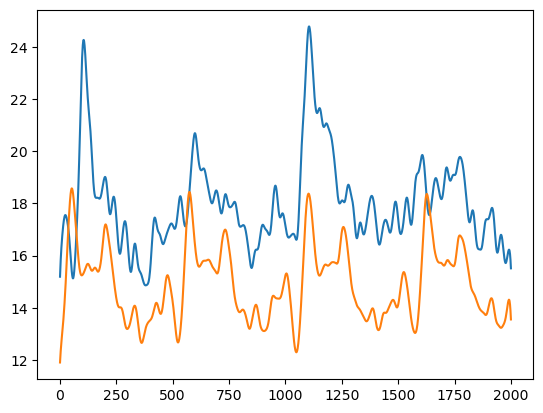

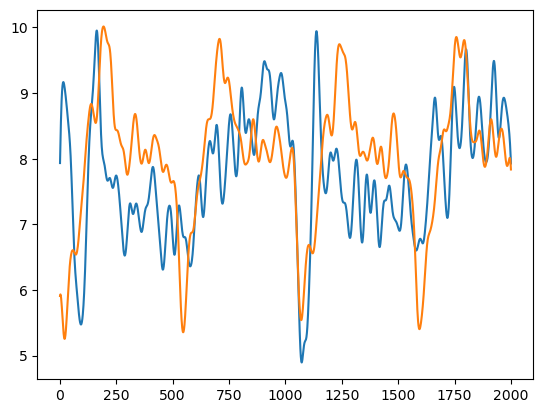

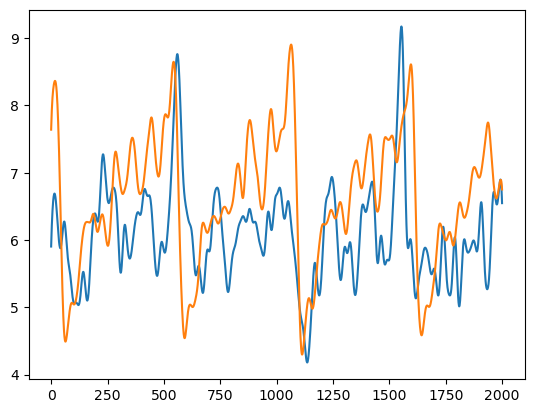

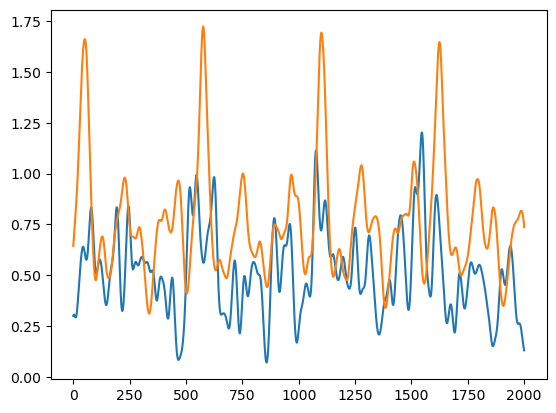

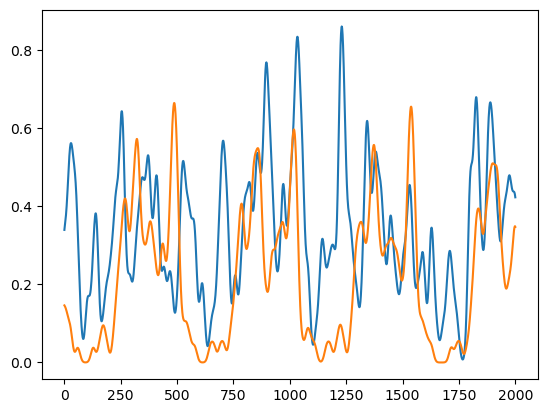

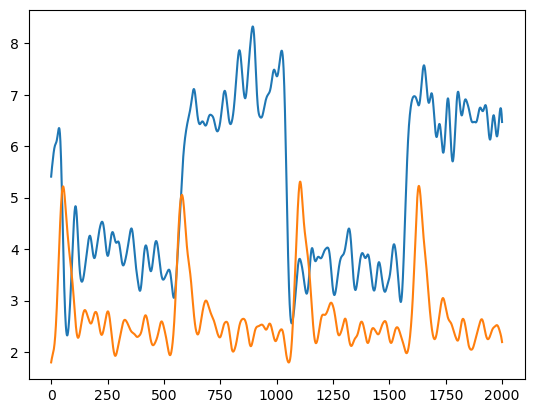

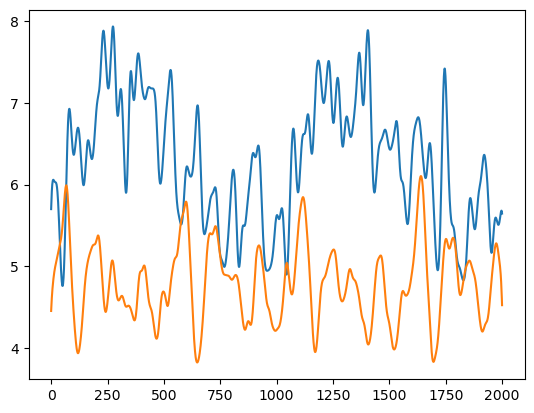

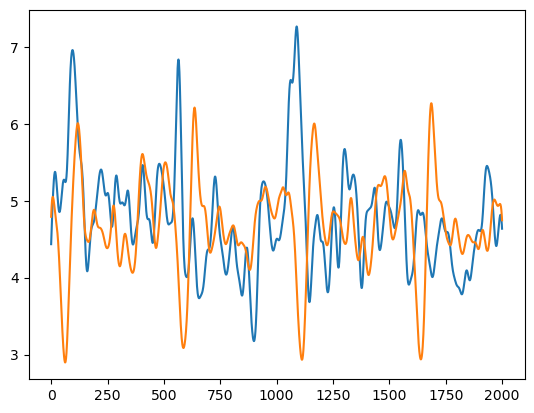

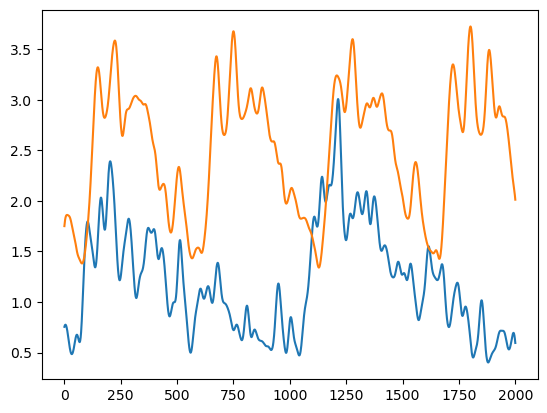

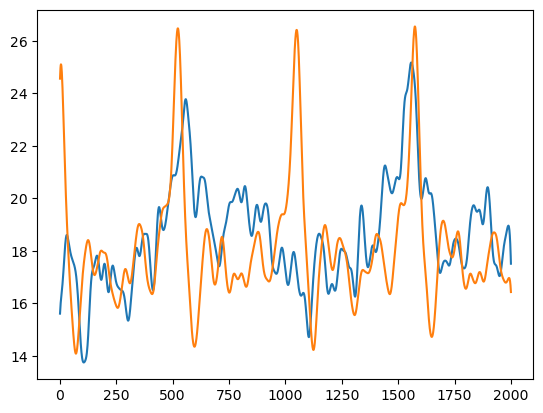

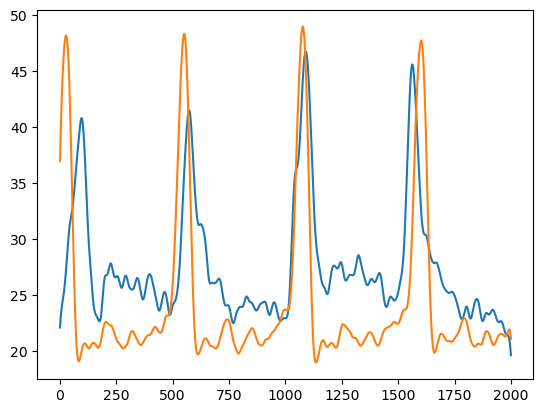

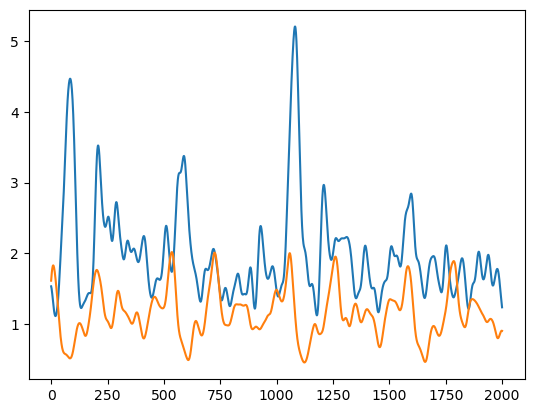

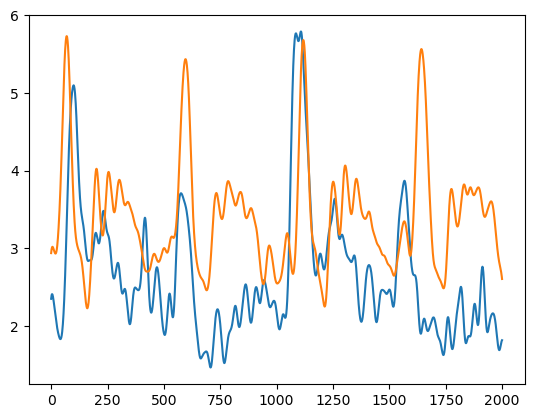

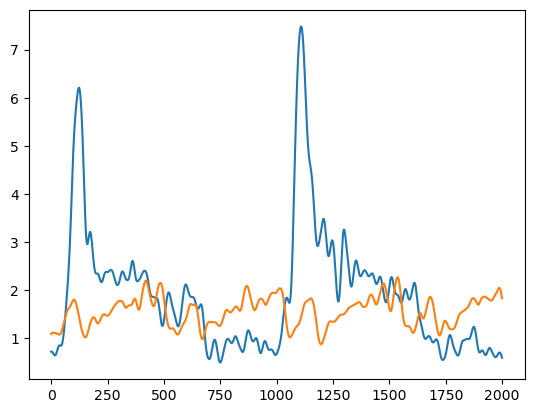

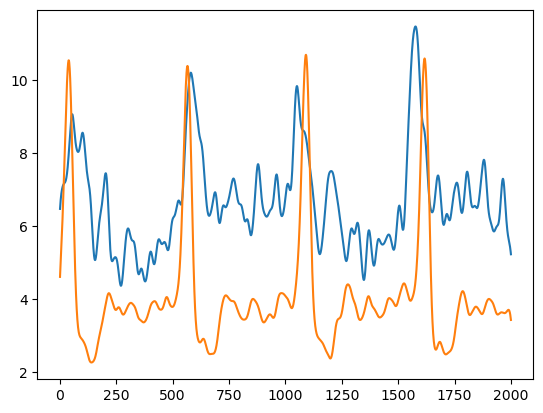

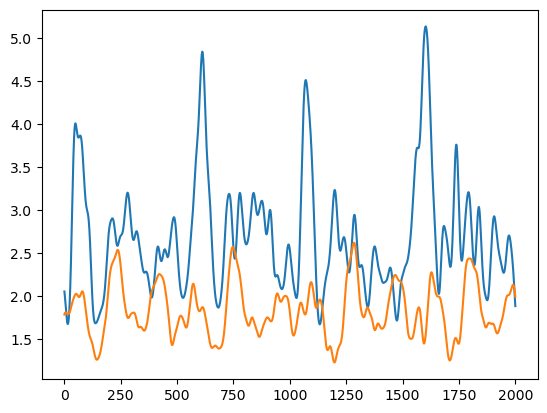

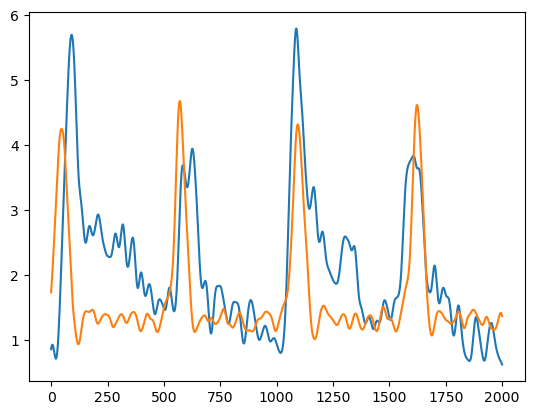

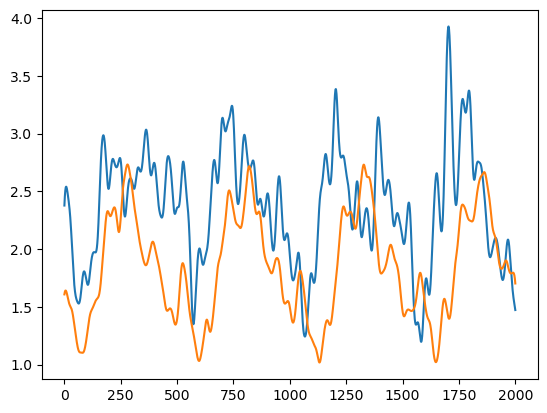

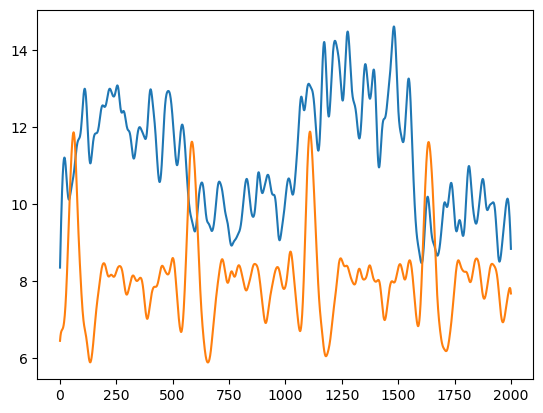

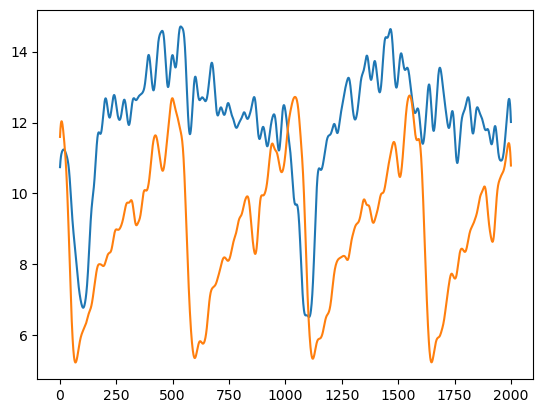

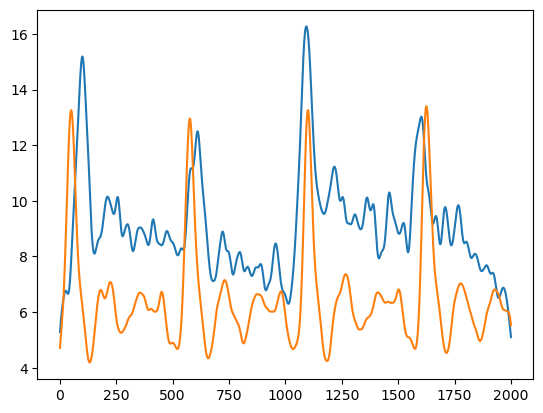

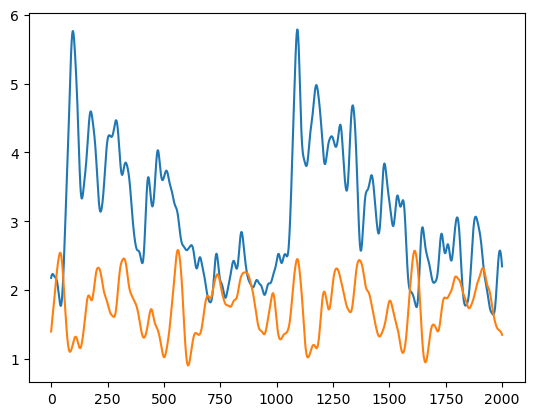

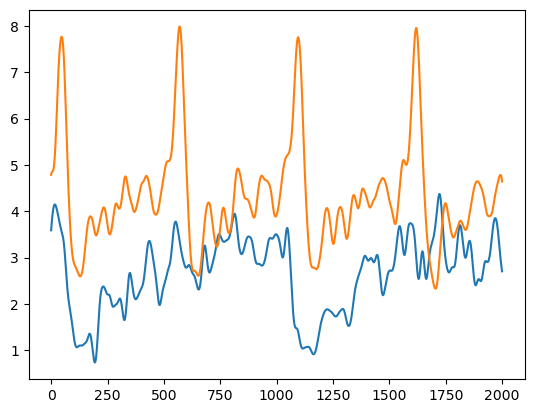

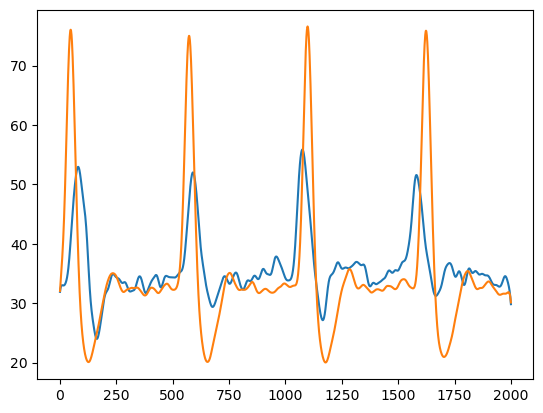

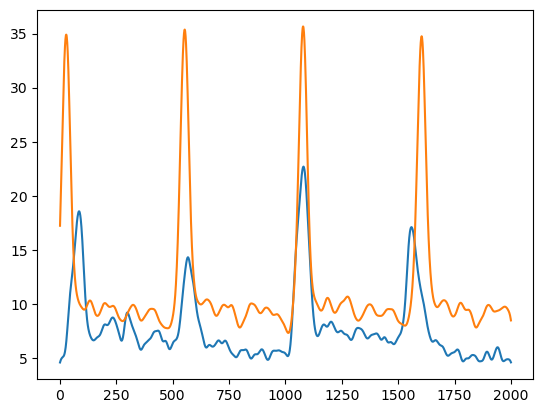

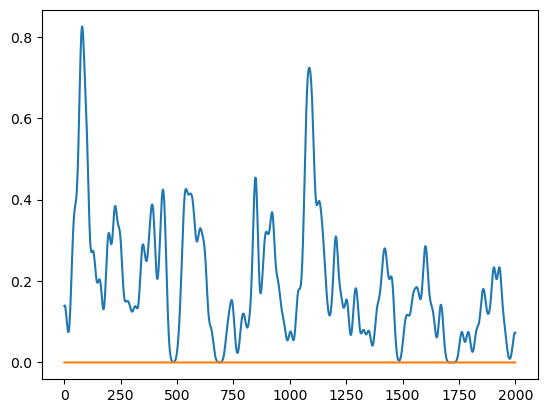

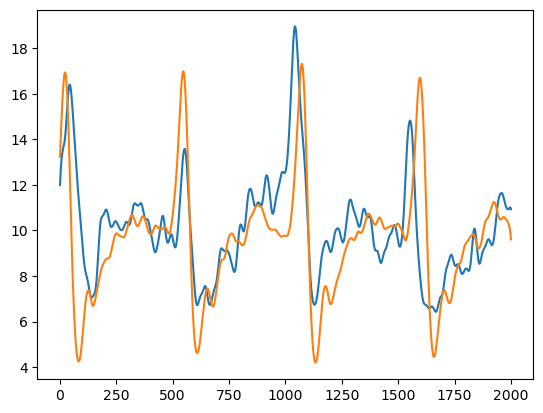

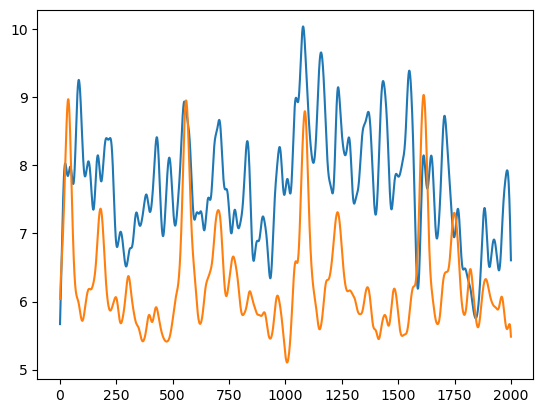

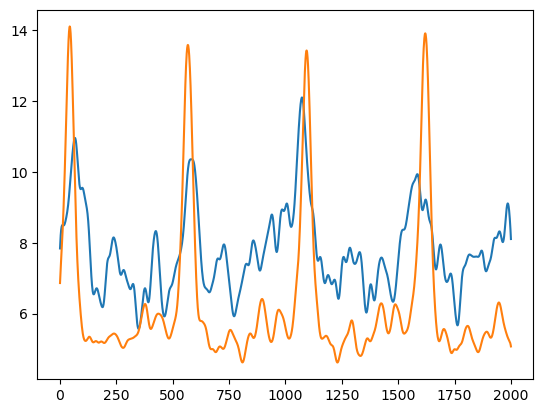

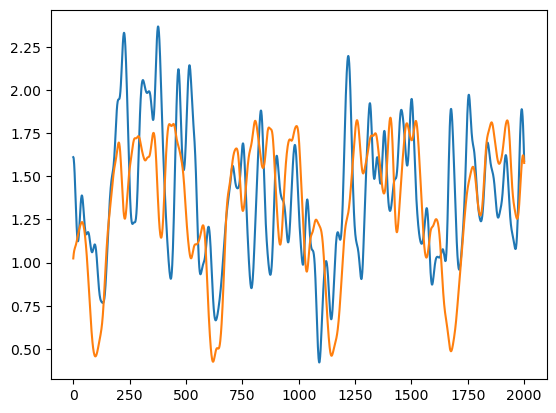

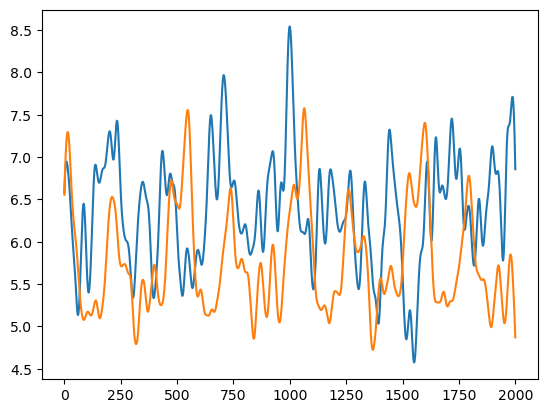

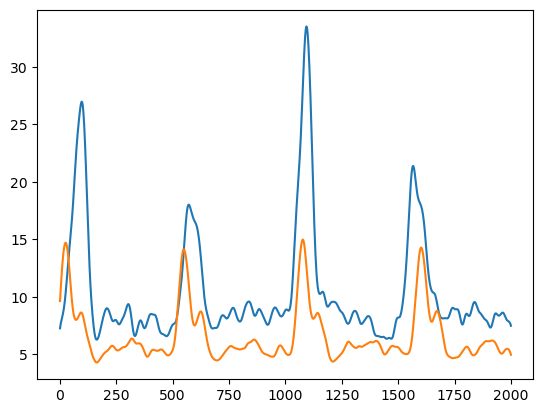

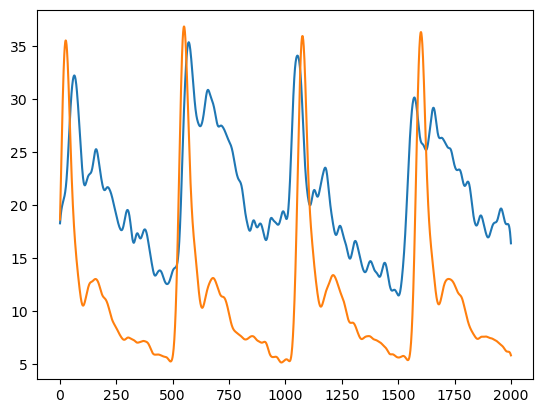

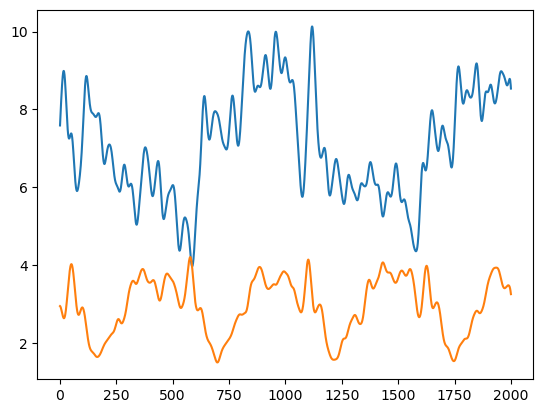

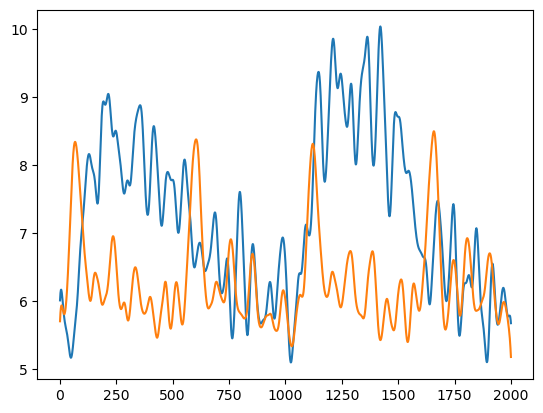

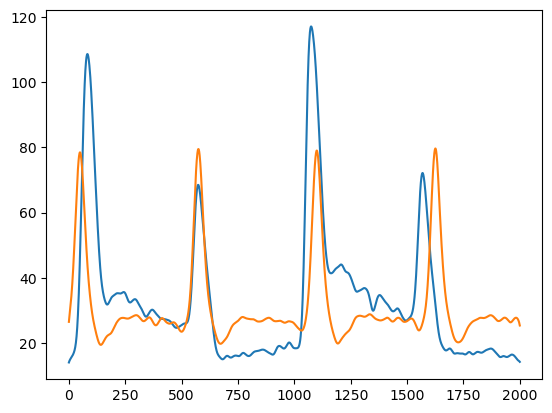

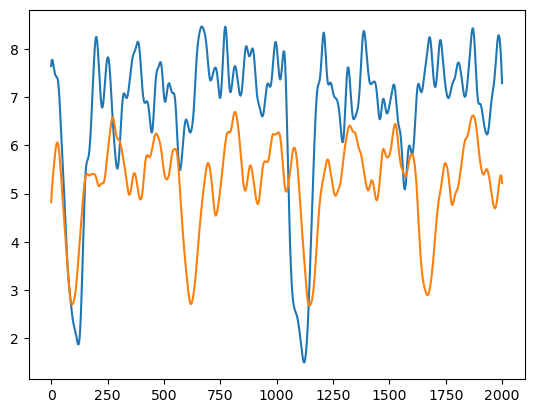

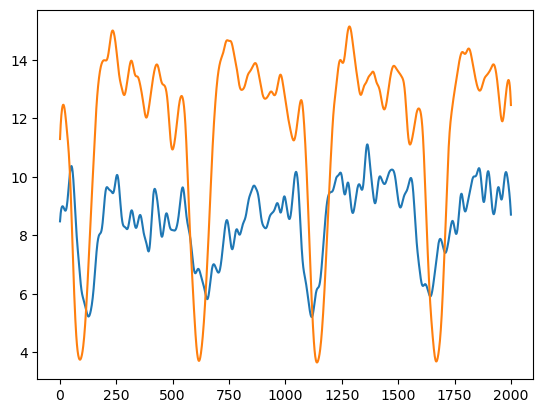

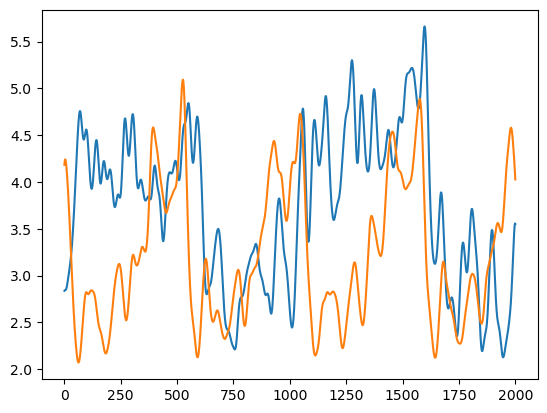

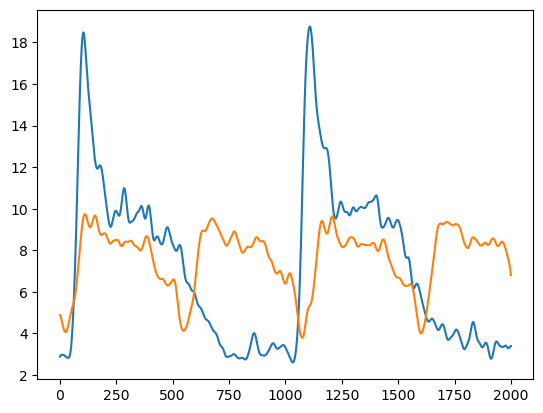

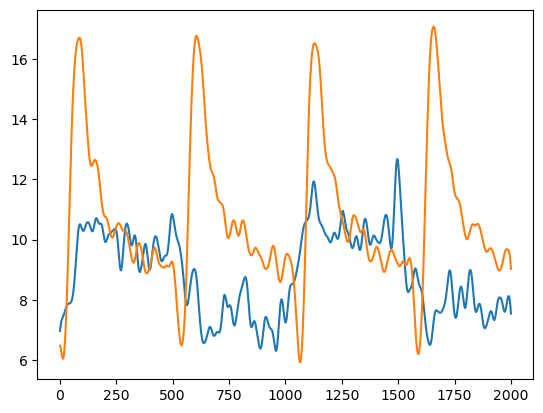

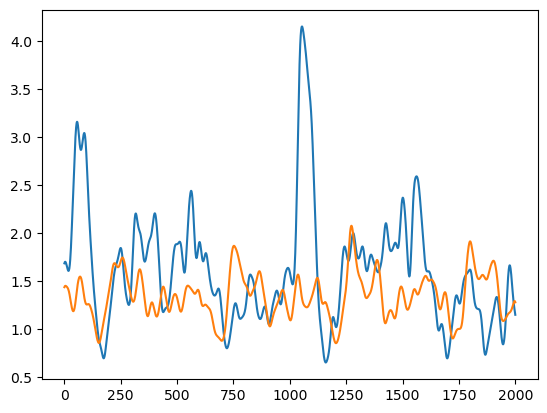

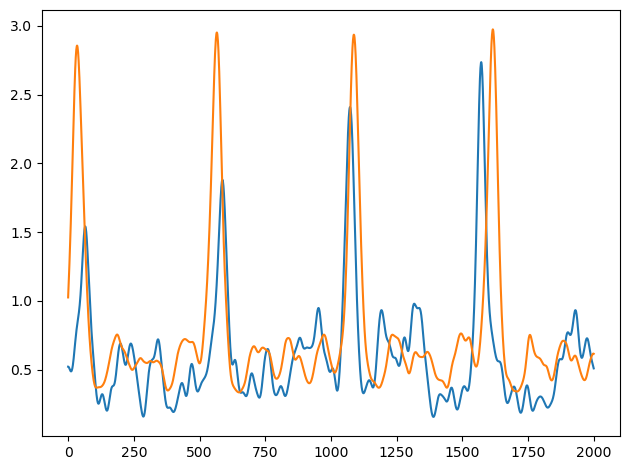

In [149]:
# plt.subplots(8,10, figsize=(10,10))
for i in range(np.size(Sn_psth,0)):
    # plt.subplot(8,10,i+1)
    plt.figure()
    plt.plot(Sn_psth[i,:,0])
    plt.plot(Rc_df.loc[i,'Rc_stim_PSTH'])
    
plt.tight_layout()

In [ ]:
eventT = self.worldT[flips+1] - self.ephysT0

rf_xy = np.zeros([len(self.cells.index.values),4]) # [unit#, on x, on y, off x, off y]
on_Sn_psth = np.zeros([len(self.cells.index.values), 2001, 4]) # shape = [unit#, time, all/ltd/on/not_rf]
off_Sn_psth = np.zeros([len(self.cells.index.values), 2001, 4])
for cell_i, ind in tqdm(enumerate(self.cells.index.values)):
    unit_sta = self.sta[cell_i]
    on_stim_history, on_xy, off_stim_history, off_xy = self.calc_RF_stim(unit_sta, vid)
    rf_xy[cell_i,0] = on_xy[0]; rf_xy[cell_i,1] = on_xy[1]
    rf_xy[cell_i,2] = off_xy[0]; rf_xy[cell_i,3] = off_xy[1]
    # spikes
    unit_spikeT = self.cells.loc[ind, 'spikeT']
    if len(unit_spikeT)<10: # if a unit never fired during revchecker
        continue
    # on subunit
    all_eventT, offT, onT, backgroundT = self.sort_lum(on_stim_history, eventT, self.eyeT, flips)
    if len(offT)==0 or len(onT)==0:
        on_Sn_psth[cell_i,:,:] = np.nan
        continue

    _event_names = ['allT', 'darkT', 'lightT', 'bckgndT']
    unit_stim_eventT = {}
    for i, n in enumerate(_event_names):
        unit_stim_eventT['onSubunit_eventT_{}'.format(n)] = [all_eventT, offT, onT, backgroundT][i] + _offset_time

    # print('all={} off={}, on={}, background={}'.format(len(all_eventT), len(offT), len(onT), len(backgroundT)))
    _offset_time = (1/120)
    on_Sn_psth[cell_i,:,0] = self.calc_kde_PSTH(unit_spikeT, all_eventT+_offset_time)
    on_Sn_psth[cell_i,:,1] = self.calc_kde_PSTH(unit_spikeT, offT+_offset_time)
    on_Sn_psth[cell_i,:,2] = self.calc_kde_PSTH(unit_spikeT, onT+_offset_time)
    on_Sn_psth[cell_i,:,3] = self.calc_kde_PSTH(unit_spikeT, backgroundT+_offset_time)

    # off subunit
    all_eventT, offT, onT, backgroundT = self.sort_lum(off_stim_history, eventT, self.eyeT, flips)
    if len(offT)==0 or len(onT)==0:
        on_Sn_psth[cell_i,:,:] = np.nan
        continue

    for i, n in enumerate(_event_names):
        unit_stim_eventT['offSubunit_eventT_{}'.format(n)] = [all_eventT, offT, onT, backgroundT][i] + _offset_time

    # print('all={} off={}, on={}, background={}'.format(len(all_eventT), len(offT), len(onT), len(backgroundT)))
    off_Sn_psth[i,:,0] = self.calc_kde_PSTH(unit_spikeT, all_eventT+_offset_time)
    off_Sn_psth[i,:,1] = self.calc_kde_PSTH(unit_spikeT, offT+_offset_time)
    off_Sn_psth[i,:,2] = self.calc_kde_PSTH(unit_spikeT, onT+_offset_time)
    off_Sn_psth[i,:,3] = self.calc_kde_PSTH(unit_spikeT, backgroundT+_offset_time)

    self.unit_stim_eventT[cell_i] = unit_stim_eventT

self.on_Sn_psth = on_Sn_psth
self.off_Sn_psth = off_Sn_psth
self.rf_xy = rf_xy
self.all_stimT = eventT+_offset_time